# Adaptive Curriculum for the Hole in Wall Task

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../')
import scriptinit
import numpy as np
import numpy.random as npr
import numpy.linalg as npla
from matplotlib.pyplot import *
from pyrl.algorithms.uvfa import *
from pyrl.algorithms.valueiter import *
from pyrl.tasks.gridworld import *
from pyrl.algorithms.nn import *
from pyrl.agents.agent import *
from pyrl.agents.multitask import *
from pyrl.algorithms.multitask import *
import pyrl.agents.arch as arch
from pyrl.prob import *
from pyrl.utils import *
from pyrl.evaluate import *

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
def showV(v):
    imshow(v.reshape(H, W), interpolation='none')
    plt.axis('off')
#     print v
    
def showExperience(agent):
    task_types = set(agent.experience_task)
    task_percent = dict()
    for task in task_types:
        task_percent[task] = sum([e == task for e in agent.experience_task])
#     total = sum(task_percent.values())
    total = 1.
    return {key: val / float(total) for (key, val) in task_percent.items()}

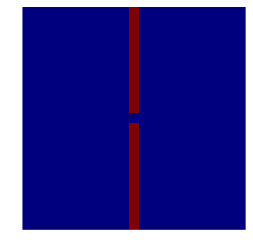

In [3]:
# world 1
H = W = 21
world = np.zeros((H, W))
world[:10, 10] = 1
world[11:, 10] = 1
showV(world)

In [5]:
two_layer_arch = lambda states: arch.two_layer(states, H * W * 2, 32, 4)
grid = Grid(world, action_stoch=0.2)
tol = 1e-6
goal = {(20, 20): 1.}


In [21]:
max_steps = 3.
gamma = tol ** (1. / max_steps)
tasks = []
for ni in range(1, 21, 2):
    for nj in range(1, 21, 2):
        tasks.append(GridWorldUltimateFixedStart(grid.state_id[(ni,nj)], grid_env=grid, goal=goal, demons={}, rewards=goal, wall_penalty=0., gamma=gamma))        

# Log-Linear Model

In [22]:
class SingleLearnerLogLinear(object):
    def __init__(self, dqn, tasks, mab_gamma, mab_scale, mab_batch_size, **kwargs):
        self.dqn = dqn
        self.tasks = tasks
        self.log_weights = [0. for task in tasks]
        self.deepQlearn = DeepQlearn(tasks[0], dqn, **kwargs)
        self.last_task = 0
        self.last_performance = 0.
        self.last_performances = {}
        self.performance_history = {}
        self.last_progress = 0.
        self.feat_last_progress = {}
        for ti, task in enumerate(self.tasks):
            self.last_performance += reward_tabular_normalized_fix_start(self.dqn, task, tol=1e-4)
            self.performance_history[ti] = []
        print 'initial performance', self.last_performance

    def run(self, num_epochs=1, budget=100):
        num_tasks = len(self.tasks)
        for epoch in range(num_epochs):
            # choose task based on weights.
            taski = -1
            p = np.exp(prob.normalize_log(self.log_weights))
            taski = npr.choice(range(num_tasks), 1, replace=True, p=p)[0]
                
            task = self.tasks[taski]
            self.last_task = taski

            # (TODO) this breaks away the abstraction.
            self.deepQlearn.task = task
            self.dqn.task = task

            # run training.
            self.deepQlearn.run(budget = budget)

            # update weights.
            performance = 0.
            self.last_performances = {}
            for ti, task in enumerate(self.tasks):
                self.last_performances[ti] = reward_tabular_normalized_fix_start(self.dqn, task, tol=1e-4)
                self.performance_history[ti].append(self.last_performances[ti])
                performance += self.last_performances[ti]
            progress = performance - self.last_performance
            self.feat_last_progress[taski] = progress
            self.last_performance = performance
            self.last_progress = progress
            
            for ti in range(num_tasks):
                self.log_weights[ti] = 0.
                self.log_weights[ti] += 30 * self.feat_last_progress[ti] if ti in self.feat_last_progress else 0.
                self.log_weights[ti] -= 100 if ti in self.last_performances and self.last_performances[ti] > 0.9 else 0.



In [23]:
dqn = DQN(tasks[0], two_layer_arch)
learner = SingleLearnerLogLinear(dqn, tasks, mab_gamma = 0.2, mab_scale = 30., mab_batch_size = 10000)

initial performance 0.00654015653838


In [24]:
for it in range(30):
    learner.run(num_epochs=1, budget=100)
    print 'task', learner.last_task
    print 'progress', learner.last_progress
    print 'performance', learner.last_performances
    print 'performance', learner.last_performance
    print np.exp(normalize_log(learner.log_weights))
    print learner.log_weights
    print 

task 41
progress 0.0
performance {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.0, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 86: 0.0, 87: 0.0, 88: 0.0, 89: 0.0, 90: 0.0, 91: 0.0, 92: 0.0, 93: 0.0, 94: 0.0, 95: 0.0, 96: 0.0, 97: 0.0, 98: 0.0, 99: 0.006540156538379951}
performance 0.00654015653838
[ 0.01  0.01  0.01  0.01  0.01

**Note** For small tasks (the ones with short time horizon), it's easier to train, but very hard to find the high-reward ones, because the task space is big.

## performance as signal

For this task, it seems initial performance in $[0.1, 0.9]$ provides a strong signal that we can still improve on this task.

In [28]:
class SingleLearnerLogLinear(object):
    def __init__(self, dqn, tasks, mab_gamma, mab_scale, mab_batch_size, **kwargs):
        self.dqn = dqn
        self.tasks = tasks
        self.log_weights = [0. for task in tasks]
        self.deepQlearn = DeepQlearn(tasks[0], dqn, **kwargs)
        self.last_task = 0
        self.last_performances = {}
        self.performance_history = {}
        self.last_progress = 0.
        self.feat_last_progress = {}
        self.last_performance = 0.
        for ti, task in enumerate(self.tasks):
            self.last_performances[ti] = reward_tabular_normalized_fix_start(self.dqn, task, tol=1e-4)
            self.last_performance += self.last_performances[ti]
            self.performance_history[ti] = []
        self.time = 0
        print 'initial performance', self.last_performance

    def run(self, num_epochs=1, budget=100):
        num_tasks = len(self.tasks)
        for epoch in range(num_epochs):
            for ti in range(num_tasks):
                self.log_weights[ti] = 0.
                self.log_weights[ti] += 100 * self.feat_last_progress[ti] if ti in self.feat_last_progress else 0.
                self.log_weights[ti] -= 1000 if ti in self.last_performances and self.last_performances[ti] > 0.9 else 0.
                if self.time < 5:
                    self.log_weights[ti] += self.last_performances[ti] * 100
                
            # choose task based on weights.
            taski = -1
            p = np.exp(prob.normalize_log(self.log_weights))
            taski = npr.choice(range(num_tasks), 1, replace=True, p=p)[0]
                
            task = self.tasks[taski]
            self.last_task = taski

            # (TODO) this breaks away the abstraction.
            self.deepQlearn.task = task
            self.dqn.task = task

            # run training.
            self.deepQlearn.run(budget = budget)

            # update weights.
            performance = 0.
            self.last_performances = {}
            for ti, task in enumerate(self.tasks):
                self.last_performances[ti] = reward_tabular_normalized_fix_start(self.dqn, task, tol=1e-4)
                self.performance_history[ti].append(self.last_performances[ti])
                performance += self.last_performances[ti]
            progress = performance - self.last_performance
            self.feat_last_progress[taski] = progress
            self.last_performance = performance
            self.last_progress = progress
            
            self.time += 1


In [32]:
dqn = DQN(tasks[0], two_layer_arch)
learner = SingleLearnerLogLinear(dqn, tasks, mab_gamma = 0.2, mab_scale = 30., mab_batch_size = 10000)

initial performance 0.947695653594


In [33]:
for it in range(30):
    learner.run(num_epochs=1, budget=100)
    print 'task', learner.last_task
    print 'progress', learner.last_progress
    print 'performance', learner.last_performances
    print 'performance', learner.last_performance
    print np.exp(normalize_log(learner.log_weights))
    print learner.log_weights
    print 

task 37
progress 0.0
performance {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.0, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 86: 0.0, 87: 0.0, 88: 0.0, 89: 0.0, 90: 0.0, 91: 0.0, 92: 0.0, 93: 0.0, 94: 0.0, 95: 0.0, 96: 0.0, 97: 0.0, 98: 0.0, 99: 0.94769565359370755}
performance 0.947695653594
[ 0.01010101  0.01010101  0.01010

KeyboardInterrupt: 

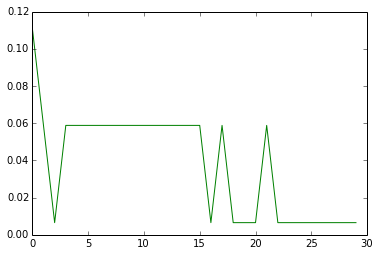

In [14]:
figure()
for ti in range(len(tasks)):
    plot(learner.performance_history[ti])

In this tiny example, we have shown that for easier tasks (shorter horizon and closer distance to goal), the model is able to predict and identify those tasks. This allows the model to create a curriculum automatically from this pool of tasks.